# 数据分析

## 加载已处理数据

In [1]:
import os
path = r'*\Data_slided\data_processed'
print(os.listdir(path))
# os.walk(file_dir) 

['.ipynb_checkpoints', 'Dis_10_stall2.csv', 'Dis_40_stall1.csv', 'Dis_70_stall1.csv', 'injection_distortion0_injected_120slpm_stall1.csv', 'injection_distortion0_injected_50slpm_stall1.csv', 'injection_distortion0_injected_70slpm_stall1.csv', 'injection_distortion10_injected_120slpm_stall1.csv', 'injection_distortion10_injected_50slpm_stall1.csv', 'injection_distortion10_injected_70slpm_stall1.csv', 'injection_distortion40_injected_120slpm_stall1.csv', 'injection_distortion40_injected_50slpm_stall1.csv', 'injection_distortion40_injected_70slpm_stall1.csv', 'injection_distortion70_injected_120slpm_stall1.csv', 'injection_distortion70_injected_50slpm_stall1.csv', 'injection_distortion70_injected_70slpm_stall1.csv', 'readme.md', 'uniforminflowtest4.csv']


## 生成子序列

In [65]:
import random

for file_i in [i for i in os.listdir(path) if 'stall1.csv' in i]:
    path_file_i = path + '\\' + file_i
    df = pd.read_csv(path_file_i).T    # 行数为样本量，列数为
    k=1           # 构建单通道数据需要额外设置通道数
#     df_j = df.iloc[:,j]
    # 通过可视化分析看到传感器感知失速团的绝对时间为30ms左右，则设置用于子序列样本异常检测的绝对长度为30ms，体现在已处理数据的长序列上为30个样本点
    len_sub_series = 10
    # 等间隔/随机充分采样（采样量达到总序列长度与子序列长度之比的 3 倍，By 奈奎斯特采样定理）
    start_points_sampling = sorted(random.sample(range(len_sub_series),1))
    print("等间隔采样起始点：{}".format(start_points_sampling))
    samples_sub_series = []
    for i in range(0,df.shape[0]-2*len_sub_series,len_sub_series):
        for j in start_points_sampling:
            sub_series = df.iloc[i+j:i+j+len_sub_series,k].values    # k=1,选取第二条传感器通道作为信号来源进行后续分析
            samples_sub_series.append(sub_series)
    samples_sub_series = np.array(samples_sub_series)
    break  # 先以一次试验的数据生成样本

# 异常检测
## 计算每个子序列的方差
std_samples = np.std(samples_sub_series, axis=1)
print(sorted(std_samples)[:10])
## 基于3σ找出离群样本


等间隔采样起始点：[8]
[0.027215144549658503, 0.035661873578728666, 0.03825807250956197, 0.039191100546967304, 0.04007411346118659, 0.0416754527576888, 0.041735519873165684, 0.042808678521008156, 0.04285975397885883, 0.043335650164185245]


# 失速状态预警

*思路一： 基于序列相似性度量的策略（DTW度量/一维卷积度量）*   

    ① 数据预处理（下采样/平滑/滤波，零均值化（去除系统误差）），降低度量计算量
    ② 异常检测定位失速团
    ③ 主动降噪，并提取失速信号
    ④ 计算失速团的失稳演化-时间松弛因子，基于非线性系统考虑，构建指数型演化规律
    ⑤ 设置对应失速团不同发展阶段/形态的对照子序列，方便检测时可以多通道应用滑动窗口计算DTW
    ⑥ 按照对照子序列长度截取最新的信号分别进行度量计算，度量计算结果的最小值对应的失速团发展形态即为最新信号所处阶段
    ⑦ 调参涉及：滤波，失速信号的自动提取，松弛因子的计算，DTW或者卷积的计算

    
*思路二： 基于时序异常检测的模式检测*   


    ① 基于tods包实现时序异常检测并构建失速团时序形态


*思路三： 基于DME分解的阈值判定策略*   

    ① 对原始信号进行EMD分解
    ② 提取低频IMF叠合出与原信号近似的整合序列
    ③ 设置预警阈值
    ④ 对新引入信号进行EMD分解，比对关键分量数值大小并计算预警时间
    
*思路四： 基于序列特征工程的距离度量（有监督学习的思路）*   
    
    ① 构建序列的经典特征（By tsfel）并扩充特征（a.序列前半段和后半段的特征变化，b. ？）
    ② 生成结构化数据并标注，异常检测，特征选择
    ③ 计算距离，
    ④ 设定类间最大距离为阈值
    ⑤ 设置误报率和漏报率检验方法可行性

## 加载数据

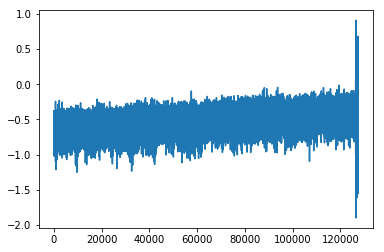

In [123]:
# 加载原始数据
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #导入绘图库


cut_point_for_visual = 126000

path_file = path + "\\injection_distortion40_injected_120slpm_stall1.csv"
df = pd.read_csv(path_file).T
whole_series = df.iloc[5:,1].values   # 第二通道的序列
# plt.plot(whole_series[cut_point_for_visual:cut_point_for_visual+1000]) 
plt.plot(whole_series) 
plt.show()
# plt.savefig("H:\\2020-09-07_失速预警\\Compresser Stall Problem\\Figure_signal_visual\\2021_06_13.svg")


## 信号处理

### 去除基线漂移

D:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


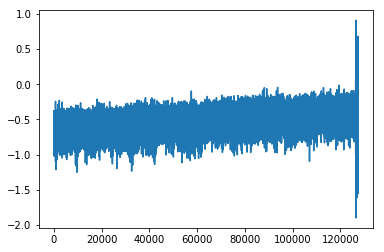

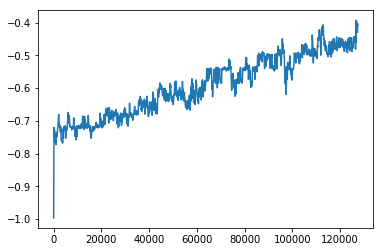

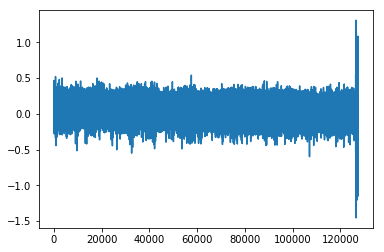

In [124]:
#  基于低通滤波去除基线漂移
from scipy import signal
import matplotlib.pyplot as plt

b, a = signal.butter(8, 0.009, 'lowpass')
filtedData = signal.filtfilt(b, a, whole_series)

plt.plot(whole_series) 
plt.show()
plt.plot(filtedData) 
plt.show()
plt.plot(whole_series - filtedData) 
plt.show()

whole_series_ = whole_series - filtedData  # 去除基线漂移


### 滑窗处理

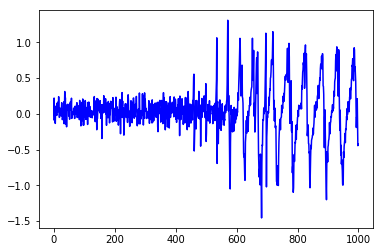

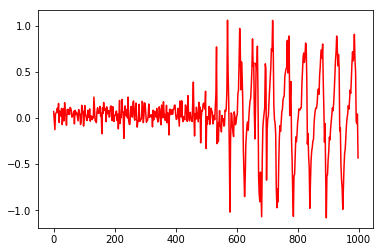

In [20]:
import numpy as np
import random
def slide_window_process(series, window_size):
    start_point = random.randint(0,window_size)
    index_x = []
    x = []
    for i in range(0,len(series),window_size):
        x.append(np.mean( series[i:i+window_size] ))
        index_x.append(i)
    
    return index_x, x

y_original = whole_series_[126000:127000]

index_x,x = slide_window_process( y_original, 2)
plt.figure(2)
plt.plot(y_original,'b')
plt.show()

plt.plot(index_x, x, 'r')
plt.show()



### 中值滤波

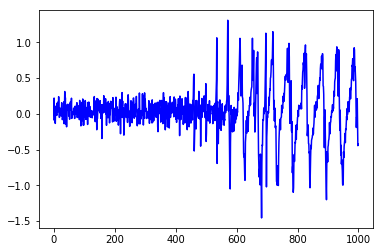

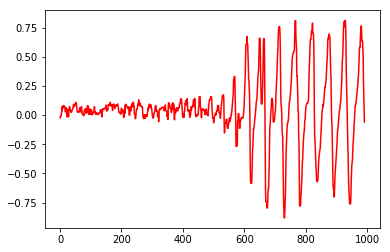

In [123]:
# 基于中值滤波器去除基线漂移

# 中值滤波器
# x为原始信号，R为某点左右邻域大小.(窗口大小=2*R+1)

def Medfilter(x,R):
    y_medfilter = []
    for i in range(R,len(x)-R):
        if i+R <= len(x) and i-R >= 1:
            med_value = np.median(x[i-R:i+R])
        elif i+R <= len(x) and i-R < 1:
            med_value = np.median(x[:i+R])
        elif i+R >= len(x) and i-R >= 1:
            med_value = np.median(x[i-R:])
        y_medfilter.append( med_value )
     
    return y_medfilter

y_original = whole_series_[126000:127000]

y_medfilter = Medfilter( y_original, 4)   # 中值滤波主要消除高频峰谷值
plt.figure(2)
plt.plot(y_original,'b')
plt.show()

plt.plot(y_medfilter, 'r')
plt.show()


### 低通滤波
参考博客文章：[Python实现信号滤波（基于scipy）](https://www.cnblogs.com/xiaosongshine/p/10831931.html)

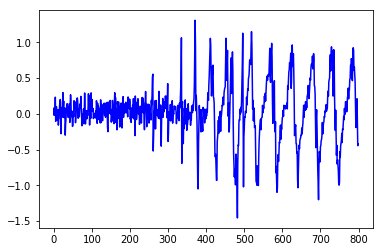

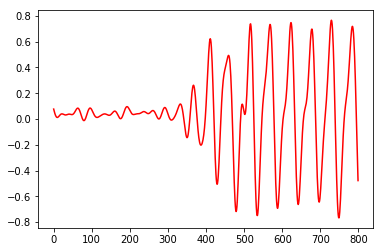

In [40]:
#这里假设采样频率为40hz,信号本身最大的频率为1hz，要滤除5hz以上频率成分，即截至频率为5hz，则wn=2*5/40=0.25

from scipy import signal

y_original = whole_series_[126200:127000]

b, a = signal.butter(8, 0.08, 'lowpass')
filted_data_lowpass = signal.filtfilt(b, a, y_original) # whole_series为要过滤的信号

plt.figure(1)
plt.plot(y_original, 'b')
plt.show()
plt.plot(filted_data_lowpass, 'r')
plt.show()


### LMS滤波
参考博客文章：[Python实现自适应LMS滤波算法](https://blog.csdn.net/moge19/article/details/89710486)

In [4]:
import numpy as np

import matplotlib.pyplot as plt
import random
import scipy as sc


#定义向量的内积
def multiVector(A,B):
    C=sc.zeros(len(A))
    for i in range(len(A)):
        C[i]=A[i]*B[i]
    return sum(C)


#取定给定的反向的个数
def inVector(A,b,a):
    D=sc.zeros(b-a+1)
    for i in range(b-a+1):
        D[i]=A[i+a]
    return D[::-1]
 

#lMS算法的函数
def LMS(xn,dn,M,mu,itr):
    en=sc.zeros(itr)
    W=[[0]*M for i in range(itr)]
    for k in range(itr)[M-1:itr]:
        x=inVector(xn,k,k-M+1)
        d= x.mean()
        y=multiVector(W[k-1],x)
        en[k]=d -y
        W[k]=np.add(W[k-1],2*mu*en[k]*x) #跟新权重
    #求最优时滤波器的输出序列
    yn=sc.inf*sc.ones(len(xn))
    for k in range(len(xn))[M-1:len(xn)]:
        x=inVector(xn,k,k-M+1)
        yn[k]=multiVector(W[len(W)-1],x)
    return (yn,en)


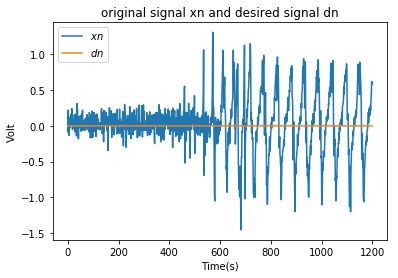

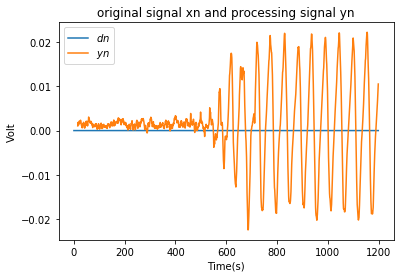

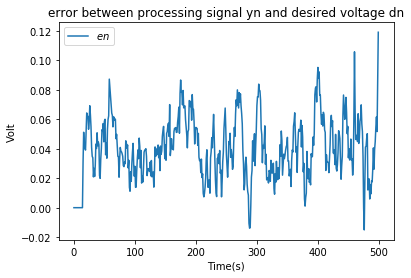

In [126]:
# 截取有源噪声
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #导入绘图库


itr=500 #采样的点数
mu =0
noise_size  = itr

y_original = whole_series_[126000:127200]
signal_noise_array = y_original

M=16 #滤波器的阶数
mu=0.001 #步长因子
xs=signal_noise_array
xn=xs #原始输入端的信号为纯噪声
dn=np.zeros(len(xs)) #对于自适应对消器，用dn作为期望

yn,en = LMS(xn,dn,M,mu,itr)

#画出图形
plt.figure(1)
plt.plot(xn,label="$xn$")
plt.plot(dn,label="$dn$")
plt.xlabel("Time(s)")
plt.ylabel("Volt")
plt.title("original signal xn and desired signal dn")
plt.legend()

plt.figure(2)
#plt.plot(xn,label="$xn$")
#plt.plot(xn,label="$xn$")
plt.plot(dn,label="$dn$")
plt.plot(yn,label="$yn$")
plt.xlabel("Time(s)")
plt.ylabel("Volt")
plt.title("original signal xn and processing signal yn")
plt.legend()

plt.figure(3)
plt.plot(en,label="$en$") 
plt.xlabel("Time(s)")
plt.ylabel("Volt")
plt.title("error between processing signal yn and desired voltage dn")
plt.legend()

plt.show()


yn_ = yn[20:]

In [146]:
# yn_ = yn[20:]
print(yn_)

[ 1.20378600e-04  1.52727023e-04  1.43359149e-04  1.42204810e-04
  1.30495560e-04  1.43355766e-04  1.67573417e-04  1.48040936e-04
  1.21284360e-04  8.93369022e-05  7.56691036e-05  7.47467506e-05
  4.49624334e-05  6.23136829e-05  5.08886124e-05  7.23205523e-05
  1.14946066e-04  9.95578198e-05  1.22729992e-04  9.03928625e-05
  9.80643291e-05  1.03663889e-04  4.12279824e-05  4.56748556e-05
  7.57957528e-05  9.61974888e-05  1.40952175e-04  1.28292787e-04
  1.44632551e-04  1.13081056e-04  1.23949582e-04  1.31039510e-04
  7.24430885e-05  9.90521526e-05  8.65971352e-05  1.33487071e-04
  1.54719290e-04  1.54677124e-04  2.13412821e-04  1.91612183e-04
  1.73213279e-04  1.63434736e-04  1.41526378e-04  1.45485157e-04
  1.26380023e-04  1.46428602e-04  1.54509675e-04  1.46503636e-04
  1.42946314e-04  1.04548994e-04  1.09384503e-04  9.50746232e-05
  7.31547940e-05  7.77958790e-05  5.26472226e-05  8.74032904e-05
  1.04277985e-04  8.92876273e-05  8.90156273e-05  8.23894948e-05
  7.86484097e-05  6.52868

### EMD滤波

## 失速团定位

### 基于k-sigma原理异常检测是实现定位

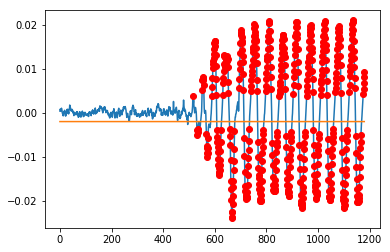

In [127]:

# 基于k-sigma异常检测原理定位失速团组位置（得到失速团群所在序列段（粗））
def find_outliers_by_3segma(data, n):
    data_std = np.std(data)
    data_mean = np.mean(data)
    outliers_cut_off = data_std*n
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    outlier_x = [i for i in range(len(data)) if data[i]<lower_rule or data[i]>upper_rule]
    outlier_y = [data[i] for i in outlier_x]
#     data_ = pd.Series(data)
#     data_.apply(lambda x: outliers.append(x) if x<lower_rule or x>upper_rule else )
#     outliers_x = data.index(outlisers)
    plt.plot(data)
    plt.plot(outlier_x, outlier_y,'ro')
    plt.plot([-0.002]*len(data))  # y=0水平线参考
    plt.show()
#     outliers_x = data.index(outlisers)
    return outlier_y, outlier_x


# yn_是去除基线漂移的数据经过LMS自适应滤波得到的结果
# 对yn_做一次零均值化，得到yn_0
yn_0mean = [i-np.mean(yn_) for i in yn_]

outlier_y, outlier_x = find_outliers_by_3segma(yn_0mean, n=0.4)



### 基于kNN原理异常检测实现定位

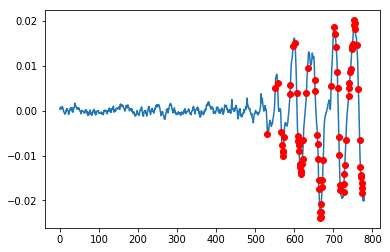

In [9]:
#-*- coding: utf-8 -*-
#基于kNN异常值检测

import numpy as np
import pandas as pd
import pyod
import matplotlib.pyplot as plt #导入绘图库

from pyod.models.knn import KNN
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

# train kNN detector
clf_name = 'KNN'
clf = KNN(n_neighbors=6)
y = yn_0mean
clf.fit(pd.DataFrame(y))

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
# y_val_pred = clf.predict(X_val)  # outlier labels (0 or 1)
# y_val_scores = clf.decision_function(df_val_X)  # outlier scores

outlier = y_train_pred #将异常值保存
outlier_y = []
outlier_x = []
for i,x in enumerate(y_train_pred):
    if x==1:
        outlier_y.append(y[i])
        outlier_x.append(i)


# print('\n异常数据如下：\n')
# print(outlier_y)
# print(outlier_x)

plt.plot(range(len(y)), y)
plt.plot(outlier_x, outlier_y, 'ro')
# # for j in range(len(outlier)):
# #     plt.annotate(outlier[j], xy=(outlier_x[j], outlier[j]), xytext=(outlier_x[j],outlier[j]))
plt.show()
# plt.savefig('2021.svg')

## 失速团形态分析

所有异常值横坐标：
[359, 367, 372, 373, 390, 396, 402, 410, 412, 413, 414, 415, 416, 417, 419, 420, 421, 423, 431, 455, 461, 462, 463, 465, 466, 467, 468, 470, 471, 472, 473, 474, 499, 503, 505, 507, 515, 516, 517, 518, 519, 525, 526, 527, 528, 529, 530, 540, 549, 550, 553, 554, 560, 569, 571, 572, 573, 579]
异常值横坐标间隔：
[8, 5, 1, 17, 6, 6, 8, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 8, 24, 6, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 25, 4, 2, 2, 8, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 10, 9, 1, 3, 1, 6, 9, 2, 1, 1, 6]


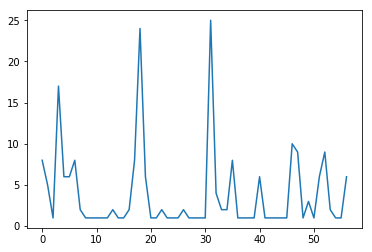

优势单边异常值横坐标：
[367, 372, 373, 410, 412, 413, 414, 415, 416, 417, 419, 420, 421, 423, 461, 462, 463, 465, 466, 467, 468, 470, 471, 472, 473, 474, 515, 516, 517, 518, 519, 525, 526, 527, 528, 529, 530, 569, 571, 572, 573, 579]
优势单边异常值横坐标间隔：
[1, 37, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 38, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 41, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 39, 2, 1, 1, 6]


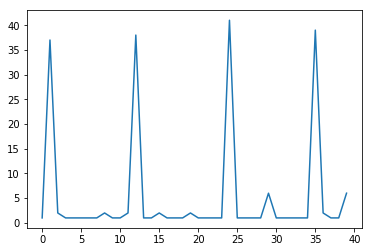

In [323]:

# 提取失速发展区段
x, y = outlier_x, outlier_y

print("所有异常值横坐标：\n{}".format(x))

x_diff = [x[i]-x[i-1] for i in range(1,len(x))]
print("异常值横坐标间隔：\n{}".format(x_diff))
plt.plot(x_diff)
plt.show()

if sum(y[:3])<=0:
    x_dominant = [i for i in x if y[x.index(i)]<=0]
else:
    x_dominant = [i for i in x if y[x.index(i)]>=0]
    
print("优势单边异常值横坐标：\n{}".format(x_dominant))
x_dominant_diff = [x_dominant[i]-x_dominant[i-1] for i in range(2,len(x_dominant))]
print("优势单边异常值横坐标间隔：\n{}".format(x_dominant_diff))
plt.plot(x_dominant_diff)
plt.show()


## 失速区段分筛

### 基于近零值点分筛（待完善）

近零值横坐标：
[286, 287, 300, 301, 302, 303, 304, 305, 306, 308, 312, 313, 326, 349, 428, 457, 478, 488, 489, 490, 491, 492, 536]


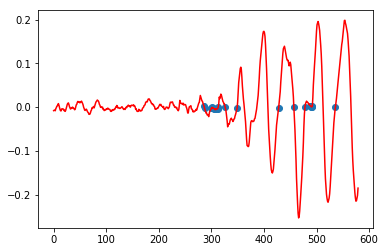

In [8]:
# 基于近零值点分筛失速区段  （未采纳,原因：数据被滤波后细节丢失，无法捕获连续的近零值点）
abs_index_base = 126000 + 20
stall_range_relative = range(outlier_x[0], outlier_x[-1])

y_0_x_relative = [i for i in stall_range_relative if abs(yn_0mean[i])<=0.004]    # abs_index_base + i
print("近零值横坐标：\n{}".format(y_0_x_relative))

plt.plot(range(len(yn_0mean)), yn_0mean, 'r')
plt.scatter(y_0_x_relative, [yn_0mean[i] for i in y_0_x_relative])
plt.show()

### 基于峰谷值分筛

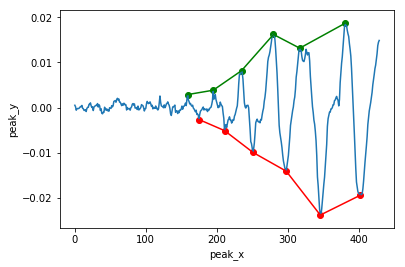

分筛出的失速区段长度依次为：
[36, 40, 45, 37, 64]


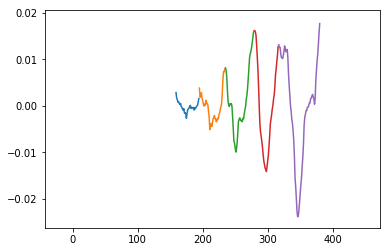

In [218]:
# 得到峰谷值
from scipy.signal import find_peaks

# 截取片段查看峰谷值提取情况
yn_0mean_ = yn_0mean[320:750]

x = range(len(yn_0mean_))
plt.plot(x,yn_0mean_)
plt.xlabel('x')
plt.ylabel('yn_')

distance_x = 15
cut_rate = 0.6


peak_x,peak_y = find_peaks(yn_0mean_, height=0, distance=distance_x)

cut_point = int(cut_rate*len(peak_x))
plt.scatter(peak_x[cut_point:], peak_y['peak_heights'][cut_point:], c='g')
plt.plot(peak_x[cut_point:], peak_y['peak_heights'][cut_point:], 'g')


yn_minus = [-i for i in yn_0mean_]
peak_x_minus, peak_y_minus = find_peaks(yn_minus, height=0, distance=distance_x)
cut_point_minus = int(cut_rate*len(peak_x_minus))
plt.scatter(peak_x_minus[cut_point_minus:], [-i for i in peak_y_minus['peak_heights']][cut_point_minus:], c='r')
plt.plot(peak_x_minus[cut_point_minus:], [-i for i in peak_y_minus['peak_heights']][cut_point_minus:], 'r')

plt.xlabel('peak_x')
plt.ylabel('peak_y')
plt.show()


# 视峰谷值提取情况分筛失速区段
stall_series = []
x_stall_series = []
for i in range(len(peak_x[cut_point:])-1):
    stall_series.append(yn_0mean_[peak_x[cut_point:][i] : peak_x[cut_point:][i+1]])
    x_stall_series.append((peak_x[cut_point:][i], peak_x[cut_point:][i+1]))

length_stall_series = [len(i) for i in stall_series]
print("分筛出的失速区段长度依次为：\n{}".format(length_stall_series))

xlim_min = min(x)-0.1*max(x)
xlim_max = 1.1*max(x)

ylim_min = 1.1*min([-i for i in peak_y_minus['peak_heights']][cut_point_minus:])
ylim_max = 1.1*max(peak_y['peak_heights'][cut_point:])
for i in range(len(stall_series)):
    x_stall_series_start = x_stall_series[i][0]
    x_stall_series_end = x_stall_series[i][1]
    x_stall_series_mark = range(x_stall_series_start, x_stall_series_end)
    plt.plot( x_stall_series_mark, stall_series[i])
    plt.ylim([ylim_min, ylim_max])
    plt.xlim([xlim_min, xlim_max])
plt.show()

## 构造测试和失速序列

### 生成参考序列

#### 设计失速信号参考序列

##### 整数个失速信号

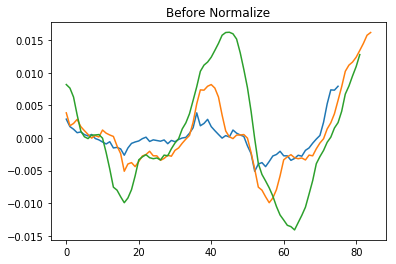

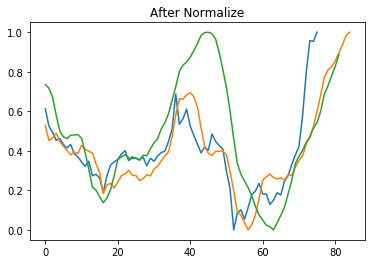

In [219]:
def normalize(series):   # 归一化可以避免序列元素的数值大小对序列形态的影响
    series_ = [(x - min(series)) / (max(series) - min(series)) for x in series]
    return series_

multi_period_sample_set = []
multi_period_sample_normalized_set = []
multi = 2
for i in range(0,len(stall_series)-multi):
    multi_period_sample = np.hstack(stall_series[i:i + multi])
    multi_period_sample_set.append(multi_period_sample)
    
    multi_period_sample_normalized = normalize(multi_period_sample)  # 归一化参考序列，直观查看相似性
    multi_period_sample_normalized_set.append(multi_period_sample_normalized)
    
for i in range(len(multi_period_sample_set)):
    plt.plot(multi_period_sample_set[i])
plt.title("Before Normalize")
plt.show()

for i in range(len(multi_period_sample_normalized_set)):
    plt.plot(multi_period_sample_normalized_set[i])
plt.title("After Normalize")    
plt.show()

ref_stall_series = multi_period_sample_set

##### 非整数个失速信号

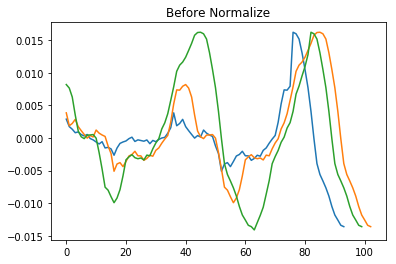

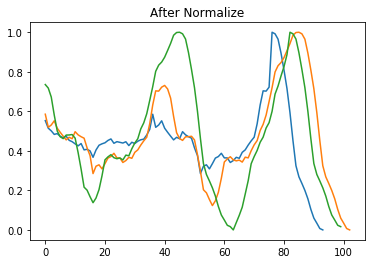

In [183]:
def normalize(series):   # 归一化可以避免序列元素的数值大小对序列形态的影响
    series_ = [(x - min(series)) / (max(series) - min(series)) for x in series]
    return series_

non_integer_multi_period_sample_set = []
non_integer_multi_period_sample_normalized_set = []
non_integer_multi = 2.5
multi = int(non_integer_multi)
decimal_part = non_integer_multi - multi

for i in range(0,len(stall_series)-multi-1):
    multi_period_sample = np.hstack(stall_series[i:i + multi])
    decimal_sample = stall_series[multi+1][:int(decimal_part*len(stall_series[multi+1]))]
    non_integer_multi_period_sample = list(multi_period_sample) + decimal_sample
    non_integer_multi_period_sample_set.append(non_integer_multi_period_sample)
    
    non_integer_multi_period_sample_normalized = normalize(non_integer_multi_period_sample)  # 归一化参考序列，直观查看相似性
    non_integer_multi_period_sample_normalized_set.append(non_integer_multi_period_sample_normalized)
    
for i in range(len(non_integer_multi_period_sample_set)):
    plt.plot(non_integer_multi_period_sample_set[i])
plt.title("Before Normalize")
plt.show()

for i in range(len(non_integer_multi_period_sample_normalized_set)):
    plt.plot(non_integer_multi_period_sample_normalized_set[i])
plt.title("After Normalize")    
plt.show()

ref_stall_series = non_integer_multi_period_sample_set

#### 计算失速信号类内距离

In [220]:
# 计算DTW距离
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import numpy as np


length_stall_series = [len(i) for i in ref_stall_series]
print("分筛出的失速区段长度依次为：\n{}\n".format(length_stall_series))

ref_stall_series_ = [np.array(i) for i in ref_stall_series]

import itertools
distances_stall = []
comb_mark = []
for i,s in enumerate(itertools.combinations(ref_stall_series_, 2)):
#     print(s[0].shape, s[1].shape)
    comb_mark.append((s[0].shape[0], s[1].shape[0]))
    s_0 = normalize(s[0])
    s_1 = normalize(s[1])
    distance = dtw.distance(s_0, s_1)
    distances_stall.append(distance)
#     break
print("失速团序列度量组合个数：\n{}\n".format(len(distances_stall)))
print("失速团序列度量结果：\n{}\n".format(distances_stall))

print("失速团序列相似性度量全部组合：\n{}\n".format(comb_mark))

min_threshold = min(distances_stall)
max_threshold = max(distances_stall)
print("失速团序列相似性度量距离\nmin:\n{}\nmax:\n{}\n".format(min_threshold, max_threshold))

min_distance_index = distances_stall.index(min_threshold)
max_distance_index = distances_stall.index(max_threshold)
comb_mark_min_distance = comb_mark[min_distance_index]
comb_mark_max_distance = comb_mark[max_distance_index]
print("失速团序列相似性度量组合\nmin:\n{}\nmax:\n{}\n".format(comb_mark_min_distance, comb_mark_max_distance))



分筛出的失速区段长度依次为：
[76, 85, 82]

失速团序列度量组合个数：
3

失速团序列度量结果：
[0.3319335997782781, 0.9440134213338635, 0.9351042493290566]

失速团序列相似性度量全部组合：
[(76, 85), (76, 82), (85, 82)]

失速团序列相似性度量距离
min:
0.3319335997782781
max:
0.9440134213338635

失速团序列相似性度量组合
min:
(76, 85)
max:
(76, 82)



### 生成测试序列

#### 从参考失速信号所在的序列生成

分筛出的失速区段长度依次为：
[76, 85, 82, 101]
测试信号长度为：
76



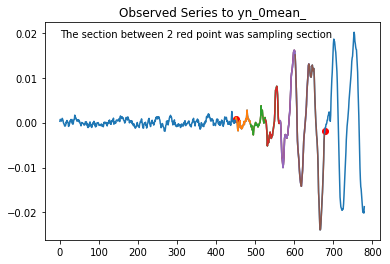

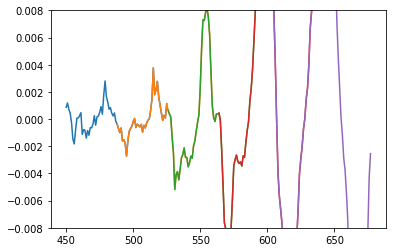

In [27]:
# 检测
# 随机采样不等长序列用于检测
import random
from dtaidistance import dtw

length_stall_series = [len(i) for i in ref_stall_series]
print("分筛出的失速区段长度依次为：\n{}".format(length_stall_series))

length_set_test_series = min(length_stall_series)
print("测试信号长度为：\n{}\n".format(length_set_test_series))
n_samples = 5

sample_method = 'uniformly_spaced'


if sample_method == 'random':
    #--------------------随机生成测试序列
    test_series = []
    sample_start = 0   # from yn_0mean
    sample_end = 350    # 失速约在yn_0mean[400]处开始
    x_test_series = []
    for i in random.sample(range(sample_start,sample_end),n_samples):   # 指定采样区间，PS：失速团所在区间为[150:420]
        test_series.append(yn_0mean[i:i+length_set_test_series ])
        x_test_series.append(range(i,i+length_set_test_series))
elif sample_method == 'uniformly_spaced':
    #--------------------等间隔生成测试序列
    test_series = []
    x_test_series = []
    step = int(length_set_test_series/2)  # step>length_set_test_series则采样不重叠，否则重叠
    # 随机设置采样区间左端点
#     sample_start = random.randint(0, 400 - n_samples*step)   # from yn_0mean  
    # 指定采样区间左端点
    sample_start = 450
    
    sample_end = sample_start + n_samples*step   # 采样量限制了等间隔采样的区间长度

    for i in range(sample_start, sample_end, step):  
        test_series.append(yn_0mean[i:i+length_set_test_series ])
        x_test_series.append(range(i,i+length_set_test_series))

# yn_0mean_ = yn_0mean[300:800]
x = range(len(yn_0mean))
plt.plot(x,yn_0mean)
plt.title("Observed Series to yn_0mean_")
plt.scatter([sample_start,sample_end+step], [yn_0mean[sample_start], yn_0mean[sample_end+step]], c='r')
plt.text(0,0.019,'The section between 2 red point was sampling section')
# plt.show()

for j in range(n_samples):
    plt.plot(x_test_series[j],test_series[j])
plt.show()

for j in range(n_samples):
    plt.plot(x_test_series[j],test_series[j])
plt.ylim([-0.008,0.008])
plt.show()


#### 从任意其他序列生成

TEST_SERIES是用于可视化的序列

test_series是用于度量的测试序列

In [137]:
import os
path = r'*\Data_slided\data_processed'
print(os.listdir(path))
# os.walk(file_dir) 


import numpy as np
import pandas as pd

## 加载数据
# path_file = path + "\\injection_distortion40_injected_120slpm_stall1.csv"   # 参考失速信号所在序列的地址
path_file_test = path + "\\injection_distortion70_injected_70slpm_stall1.csv"  # 测试信号所在序列的地址
df_test = pd.read_csv(path_file_test).T
whole_series_test = df.iloc[5:,1].values   # 第二通道的序列


['.ipynb_checkpoints', 'Dis_10_stall2.csv', 'Dis_40_stall1.csv', 'Dis_70_stall1.csv', 'injection_distortion0_injected_120slpm_stall1.csv', 'injection_distortion0_injected_50slpm_stall1.csv', 'injection_distortion0_injected_70slpm_stall1.csv', 'injection_distortion10_injected_120slpm_stall1.csv', 'injection_distortion10_injected_50slpm_stall1.csv', 'injection_distortion10_injected_70slpm_stall1.csv', 'injection_distortion40_injected_120slpm_stall1.csv', 'injection_distortion40_injected_50slpm_stall1.csv', 'injection_distortion40_injected_70slpm_stall1.csv', 'injection_distortion70_injected_120slpm_stall1.csv', 'injection_distortion70_injected_50slpm_stall1.csv', 'injection_distortion70_injected_70slpm_stall1.csv', 'readme.md', 'uniforminflowtest4.csv']


D:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


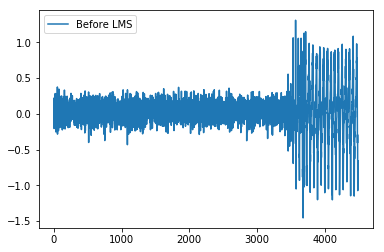

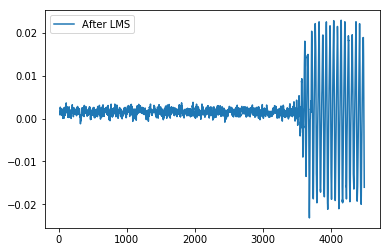

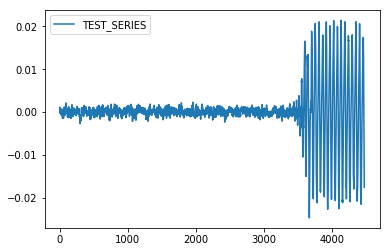

In [141]:

##  基于低通滤波去除基线漂移
from scipy import signal

def generate_test_series(whole_series):
    b, a = signal.butter(8, 0.009, 'lowpass')
    filtedData = signal.filtfilt(b, a, whole_series)

    whole_series_ = whole_series - filtedData  # 去除基线漂移

    series_to_LMS = whole_series_[123000:]    # 调整信号展示的区间

    ## LMS滤波
    itr=500 #采样的点数
    mu =0
    noise_size  = itr

    y_original = series_to_LMS
    signal_noise_array = y_original

    M=16 #滤波器的阶数
    mu=0.001 #步长因子
    xs=signal_noise_array
    xn=xs #原始输入端的信号为纯噪声
    dn=np.zeros(len(xs)) #对于自适应对消器，用dn作为期望

    yn,en = LMS(xn,dn,M,mu,itr)


    #画出图形
    plt.figure(1)
    plt.plot(xn,label="Before LMS")
    plt.legend()

    plt.figure(2)
    plt.plot(yn,label="After LMS")
    plt.legend()

    plt.show()


    ## 零均值化
    yn_ = yn[20:]
    TEST_SERIES = [i-np.mean(yn_) for i in yn_]  # yn前几个值有inf,会影响后续计算

    plt.figure(3)
    plt.plot(TEST_SERIES, label='TEST_SERIES')
    plt.legend()
    plt.show()
    
    return TEST_SERIES

TEST_SERIES = generate_test_series(whole_series_test)


##### 生成非失速段测试信号（用于计算误警率）

分筛出的失速区段长度依次为：
[76, 85, 82]
测试信号长度为：
76



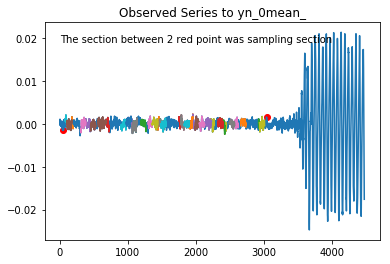

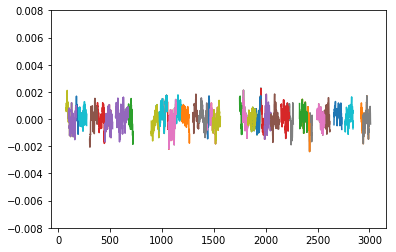

In [221]:
# 检测
# 随机采样不等长序列用于检测
import random
from dtaidistance import dtw

length_stall_series = [len(i) for i in ref_stall_series]
print("分筛出的失速区段长度依次为：\n{}".format(length_stall_series))

length_set_test_series = min(length_stall_series)
print("测试信号长度为：\n{}\n".format(length_set_test_series))
n_samples = 50

sample_method = 'random'


if sample_method == 'random':
    #--------------------随机生成测试序列 
    test_series_PFA = []   # Test series for proba False Alarm 
    sample_start = 50   ####################### Set start point
    sample_end = 3000 #sample_start + 200*n_samples    # 失速约在yn_0mean[400]处开始
    x_test_series = []
    for i in random.sample(range(sample_start,sample_end),n_samples):   # 指定采样区间，PS：失速团所在区间为[150:420]
        test_series_PFA.append(TEST_SERIES[i:i+length_set_test_series ])
        x_test_series.append(range(i,i+length_set_test_series))
elif sample_method == 'uniformly_spaced':
    #--------------------等间隔生成测试序列
    test_series_PFA = []   # Test series for proba False Alarm 
    x_test_series = []
    step = int(length_set_test_series/2)  # step>length_set_test_series则采样不重叠，否则重叠
    # 随机设置采样区间左端点
#     sample_start = random.randint(0, 400 - n_samples*step)   # from yn_0mean  
    # 指定采样区间左端点
    sample_start = 3400   ####################### Set start point
    
    sample_end = sample_start + n_samples*step   # 采样量限制了等间隔采样的区间长度

    for i in range(sample_start, sample_end, step):  
        test_series_PFA.append(TEST_SERIES[i:i+length_set_test_series ])
        x_test_series.append(range(i,i+length_set_test_series))

# yn_0mean_ = yn_0mean[300:800]
x = range(len(TEST_SERIES))
plt.plot(x,TEST_SERIES)
plt.title("Observed Series to yn_0mean_")
plt.scatter([sample_start,sample_end+step], [TEST_SERIES[sample_start], TEST_SERIES[sample_end+step]], c='r')
plt.text(0,0.019,'The section between 2 red point was sampling section')
# plt.show()

for j in range(n_samples):
    plt.plot(x_test_series[j],test_series_PFA[j])
plt.show()

for j in range(n_samples):
    plt.plot(x_test_series[j],test_series_PFA[j])
plt.ylim([-0.008,0.008])
plt.show()

##### 生成失速段测试信号（用于计算漏警率）

主要针对失速演化初期，后期的失速信号对预警没有意义

分筛出的失速区段长度依次为：
[76, 85, 82]
测试信号长度为：
76



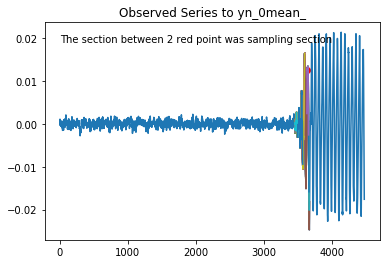

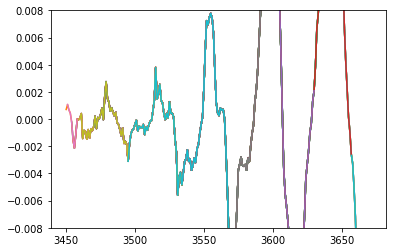

In [222]:
# 检测
# 随机采样不等长序列用于检测
import random
from dtaidistance import dtw

length_stall_series = [len(i) for i in ref_stall_series]
print("分筛出的失速区段长度依次为：\n{}".format(length_stall_series))

length_set_test_series = min(length_stall_series)
print("测试信号长度为：\n{}\n".format(length_set_test_series))
n_samples = 50

sample_method = 'random'


if sample_method == 'random':
    #--------------------随机生成测试序列
    test_series_PDA = []    # Test series for proba Dismissal Alarm
    sample_start = 3450   ####################### Set start point
    sample_end = 3600 #sample_start + 200*n_samples    # 失速约在yn_0mean[400]处开始
    x_test_series = []
    for i in random.sample(range(sample_start,sample_end),n_samples):   # 指定采样区间，PS：失速团所在区间为[150:420]
        test_series_PDA.append(TEST_SERIES[i:i+length_set_test_series ])
        x_test_series.append(range(i,i+length_set_test_series))
elif sample_method == 'uniformly_spaced':
    #--------------------等间隔生成测试序列
    test_series_PDA = []    # Test series for proba Dismissal Alarm
    x_test_series = []
    step = int(length_set_test_series/2)  # step>length_set_test_series则采样不重叠，否则重叠
    # 随机设置采样区间左端点
#     sample_start = random.randint(0, 400 - n_samples*step)   # from yn_0mean  
    # 指定采样区间左端点
    sample_start = 3400   ####################### Set start point
    
    sample_end = sample_start + n_samples*step   # 采样量限制了等间隔采样的区间长度

    for i in range(sample_start, sample_end, step):  
        test_series_PDA.append(TEST_SERIES[i:i+length_set_test_series ])
        x_test_series.append(range(i,i+length_set_test_series))

# yn_0mean_ = yn_0mean[300:800]
x = range(len(TEST_SERIES))
plt.plot(x,TEST_SERIES)
plt.title("Observed Series to yn_0mean_")
plt.scatter([sample_start,sample_end+step], [TEST_SERIES[sample_start], TEST_SERIES[sample_end+step]], c='r')
plt.text(0,0.019,'The section between 2 red point was sampling section')
# plt.show()

for j in range(n_samples):
    plt.plot(x_test_series[j],test_series_PDA[j])
plt.show()

for j in range(n_samples):
    plt.plot(x_test_series[j],test_series_PDA[j])
plt.ylim([-0.008,0.008])
plt.show()

## 状态预警

### 策略一：基于序列相似性度量

以单周期失速团信号的形态特征作为参考存在失速团对内相似性大于对外相似性的问题。考虑随机信号和失速信号的区别在于前者信号无重复而后者有重复，因此需要以多周期失速团信号的形态特征作为参考进行相似性度量。具体地就是专门设计失速信号参考序列。

#### 序列相似性可视化

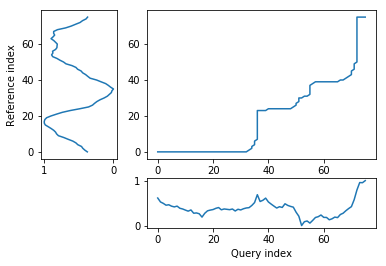

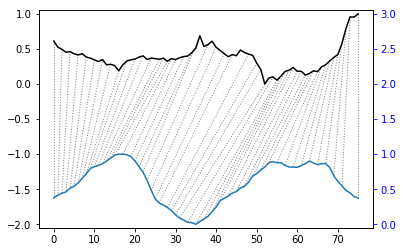

Step pattern recursion:
 g[i,j] = min(
     g[i-2,j-1] + 2 * d[i  ,j  ] ,
     g[i-1,j-1] +     d[i  ,j  ] ,
     g[i-1,j-2] +     d[i  ,j  ] ,
 ) 

Normalization hint: N



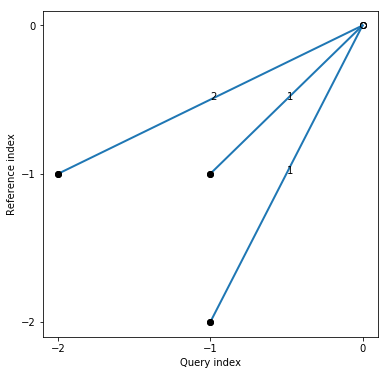

In [223]:
# 基于DTW方法相似性阈值（也即失速团区段序列间相似性度量的最小值）
import numpy as np

## series 1
series_1 = ref_stall_series[0]
series_1 = normalize(series_1)

## series 2
# series_2 = ref_stall_series[2]  
series_2 = test_series[4]
series_2 = normalize(series_2)

## Find the best match with the canonical recursion formula
from dtw import *
alignment = dtw(series_1, series_2, keep_internals=True)

## Display the warping curve, i.e. the alignment curve
alignment.plot(type="threeway")

## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
dtw(series_1, series_2, keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(3, "c")).plot(type="twoway",offset=-2)

## See the recursion relation, as formula and diagram
print(rabinerJuangStepPattern(3,"c"))
rabinerJuangStepPattern(3,"c").plot()

## And much more!



#### 度量形态相似性

度量测试信号与失速信号(组)的形态相似性
（归一化使之具有可比性）

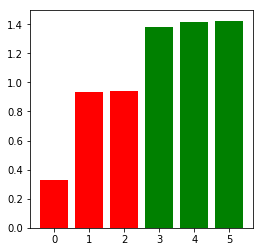

In [227]:
import itertools
from dtaidistance import dtw

def max_min_process(series):   # 归一化可以避免序列元素的数值大小对序列形态的影响
    series_ = [(x - min(series)) / (max(series) - min(series)) for x in series]
    return series_

def compare_test_series_with_stall_series(test_series, ref_stall_series):
    # 计算ref_stall_series间相似性
    ref_stall_series_ = [np.array(i) for i in ref_stall_series]
    distances_stall = []
    for i,s in enumerate(itertools.combinations(ref_stall_series_, 2)):
        s_0 = s[0]
        s_1 = s[1]
        s_0 = max_min_process(s_0)
        s_1 = max_min_process(s_1)
        distance = dtw.distance(s_0, s_1)
        distances_stall.append(distance)
    
    # 计算test_series和各个ref_stall_series的相似性
    distance_test = []
    for s_stall in ref_stall_series_: 
        s_stall = max_min_process(s_stall)
        test_series = max_min_process(test_series)
        distance_test.append(dtw.distance(test_series, s_stall))
    
    return distances_stall, distance_test

distances_stall, distance_test = compare_test_series_with_stall_series(test_series_PFA[0], ref_stall_series)

    # 相似性可视化（柱状图）
x = range(len(distances_stall) + len(distance_test))
comb_distances = sorted(distances_stall + distance_test)
x_1 = [comb_distances.index(i) for i in comb_distances if i in distances_stall]
x_2 = [comb_distances.index(i) for i in comb_distances if i in distance_test]
y_1 = [i for i in comb_distances if i in distances_stall]
y_2 = [i for i in comb_distances if i in distance_test]

fig, ax = plt.subplots(figsize=(4, 4))
ax.bar(x=x_1, height=y_1, color="red")
ax.bar(x=x_2, height=y_2, color="green")
plt.show()
    
  



#### 计算误警率和漏警率

误警率：PFA

漏警率：PDA

In [242]:
def compute_sum_of_abs(test_series_i, ref_stall_series):   #计算序列的绝对值之和，引入序列的数值性差异，便于对漏警率进行修正
    test_sum_of_abs = sum([abs(i) for i in test_series_i])
    rate_sum_of_abs_set = []
    for j in ref_stall_series:
        ref_sum_of_abs = sum([abs(i) for i in j])
        rate_sum_of_abs = test_sum_of_abs / ref_sum_of_abs
        rate_sum_of_abs_set.append(rate_sum_of_abs)
    rate_sum_of_abs_mean = np.mean(rate_sum_of_abs_set)
    print(rate_sum_of_abs_set)
    return rate_sum_of_abs_mean

rate_sum_of_abs_mean = compute_sum_of_abs(test_series_PFA[3], ref_stall_series)

[0.25703755083680446, 0.09600950609860498, 0.060489223763297885]


In [266]:
def compute_sum_of_abs(test_series_i, ref_stall_series):   #计算序列的绝对值之和，引入序列的数值性差异，便于对漏警率进行修正
    test_sum_of_abs = sum([abs(i) for i in test_series_i])
    rate_sum_of_abs_set = []
    for j in ref_stall_series:
        ref_sum_of_abs = sum([abs(i) for i in j])
        rate_sum_of_abs = test_sum_of_abs / ref_sum_of_abs
        rate_sum_of_abs_set.append(rate_sum_of_abs)
    rate_sum_of_abs_max = max(rate_sum_of_abs_set)
#     print(max(rate_sum_of_abs_set))
    return rate_sum_of_abs_max


def compute_pfa_pda(Comprehensive_proba, Proba_1, mode, Rate_sum_of_abs_max_set):
    
    
    if mode == 'PFA':
        threshold_numerical_diff = max(Rate_sum_of_abs_max_set)
    elif mode == 'PDA':
        threshold_numerical_diff = min(Rate_sum_of_abs_max_set)
    
    threshold_numerical_diff = 0.5

    count = 0
    for i in range(len(Comprehensive_proba)):
        if Rate_sum_of_abs_max_set[i] > threshold_numerical_diff or  Comprehensive_proba[i] > 0.5:
            count += 1
    stall_pred_rate = float(count / len(Comprehensive_proba))   # 判断为失速的比例
    
    
    if mode == 'PFA':
        print("预警准确率：\n{}".format(1 - stall_pred_rate)) 
        print("误警率：\n{}".format(stall_pred_rate))       # 非失速区段看误警率
    elif mode == 'PDA':
        print("预警准确率：\n{}".format(stall_pred_rate))
        print("漏警率：\n{}".format(1 - stall_pred_rate))   # 失速区段看漏警率

    return None




def PFA_PDA(test_series, ref_stall_series, mode):
    Comprehensive_proba = []
    Proba_1 = []
    Rate_sum_of_abs_max_set = []
#     print("****红色柱表示失速信号间相似性，绿色表示测试信号与失速信号（组）的相似性****\n")
    for i in range(len(test_series)):
    #     print("--------- 第{}个测试序列的相似性度量 ----------".format(i+1))
        distances_stall, distance_test = compare_test_series_with_stall_series(test_series[i], ref_stall_series)
        
        rate_sum_of_abs_max = compute_sum_of_abs(test_series[i], ref_stall_series)
        
        # 基于冗余的失速信号计算测试信号的相似情况，并设置
        proba_is_stall = []
        for j in distance_test:
            count = 0
            for k in distances_stall:
                if k < j:
                    count +=1
            p = 1-float(count/len(distances_stall))
            proba_is_stall.append(p)
        proba_1 = 1 - float(proba_is_stall.count(0.0) / len(proba_is_stall))    # 相似性突破类间距离的概率
        proba_2 =  np.mean(proba_is_stall)   # 相似性突破类间距离的程度
        comprehensive_proba = 0.8*proba_1 + 0.2*proba_2   
        Proba_1.append(proba_1)
        Comprehensive_proba.append(comprehensive_proba)
        Rate_sum_of_abs_max_set.append(rate_sum_of_abs_max)
#         print("该测试信号与各个失速信号相似度分别为：\n{}，\n综合相似度为：\n{}\n\n".format(proba_is_stall, comprehensive_proba))
    
    compute_pfa_pda(Comprehensive_proba, Proba_1, mode, Rate_sum_of_abs_max_set)
    
    return Rate_sum_of_abs_max_set

Rate_sum_of_abs_max_set_PFA = PFA_PDA(test_series_PFA, ref_stall_series, 'PFA') 
Rate_sum_of_abs_max_set_PDA = PFA_PDA(test_series_PDA, ref_stall_series, 'PDA')


# FOR Rate_sum_of_abs_mean_set[i]的判定阈值选择方法：




'''
当前最好的结果：
预警准确率：
0.98
误警率：
0.02


预警准确率：
1.0
漏警率：
0.0

其中漏警率可以通过数值差异性来降低

'''

预警准确率：
0.98
误警率：
0.02
预警准确率：
1.0
漏警率：
0.0


'\n当前最好的结果：\n预警准确率：\n0.98\n误警率：\n0.02\n\n\n预警准确率：\n1.0\n漏警率：\n0.0\n\n其中漏警率可以通过数值差异性来降低\n\n'

In [254]:
max(Rate_sum_of_abs_mean_set_PFA)

0.44407452370270606

In [257]:
min(Rate_sum_of_abs_mean_set_PDA)

0.5217294338303298

### 策略二：时序异常检测（模式检测）

依赖pyod和tods

### 策略四：序列特征的距离度量

#### 度量时序特征差异性

时序特征包括：统计学特征，时域特征，频域特征等

In [268]:
import tsfel

